# Libraries

In [1]:
from models.mtcnn import MTCNN
from models.inception_resnet_v1 import InceptionResnetV1
import torch
import os
import pickle
import cv2
import matplotlib.pyplot as plt
from PIL import Image

workers = 0 if os.name == 'nt' else 4

import warnings
warnings.filterwarnings("ignore")

# Inferencing on Facenet

### Load models

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

mtcnn = MTCNN(
image_size=160, margin=0, min_face_size=20,
thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
device=device
)

resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

Running on device: cpu


### Create Database

In [3]:
def get_embeddings(image):

    name = image.split('/')[-1].split('.')[0]
    try:
        face = mtcnn(Image.open(image))
    except:
        print("Couldn't read the image ", name)

    try:
        return resnet(face.unsqueeze(0).to(device)).detach(), name
    except Exception:
        print("Couldn't get the embeddings of image ", name)
        return None, None

In [4]:
def create_database(in_path, out_path='database.pkl'):

    images_list = os.listdir(in_path)
    embeddings_set = torch.rand(len(images_list), 1, 512)
    id_to_name = {}
    for i, image in enumerate(images_list):
        embeddings, name = get_embeddings(os.path.join(in_path, image))
        if embeddings is not None:
            embeddings_set[i] = embeddings
            id_to_name[i] = name
    database = [embeddings_set, id_to_name]

    with open(out_path,"wb") as pkl_out:
        pickle.dump(database, pkl_out)

In [5]:
create_database("data/database/images/", "data/database/database.pkl")

### Update database

In [6]:
def update_database(in_path, image, name=None):

    with open(in_path, "rb") as pkl_in: 
        database = pickle.load(pkl_in)
        
    embeddings_set, id_to_name = database

    if name:
        embeddings, _ = get_embeddings(image)
    else:
        embeddings, name = get_embeddings(image)

    if embeddings is not None:
        embeddings_set = torch.cat((embeddings_set, embeddings.reshape(1, 1, -1)), dim=0)
        id_to_name[len(id_to_name)] = name
        
    database = [embeddings_set, id_to_name]

    with open(in_path,"wb") as pkl_out:
        pickle.dump(database, pkl_out)

In [7]:
update_database("data/database/database.pkl", 'data/Chadwick_Boseman.jpg', name="Chadwick_Boseman")

### Face Verification

Verify if the 2 given images are of the same person or not.

#### Verify image by image

In [8]:
def verify_by_image(image1, image2, threshold=0.5):

    image1 = Image.open(image1);image2 = Image.open(image2)

    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(image1)
    f.add_subplot(1,2, 2)
    plt.imshow(image2)
    plt.show(block=True)

    aligned1 = mtcnn(image1);aligned2 = mtcnn(image2)

    try:
        embeddings1 = resnet(aligned1.unsqueeze(0).to(device)).detach()
        embeddings2 = resnet(aligned2.unsqueeze(0).to(device)).detach()
        dist = (embeddings1 - embeddings2).norm().item()
        if dist < threshold:print('Verified: Same person | Score {}'.format(1-dist))
        else:print('Verified: Different persons | Score {}'.format(1-dist))
    except Exception:
        print('Something is wrong with one of the images. Please provide a better image!')

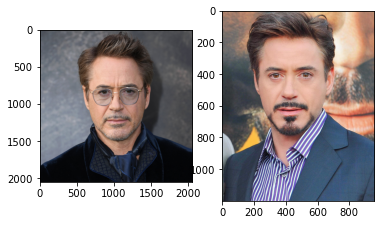

Verified: Same person | Score 0.3027321696281433


In [9]:
image1 = "data/test/Robert_Downey_Jr.jpg"
image2 = "data/database/images/Robert_Downey_Jr.jpg"

verify_by_image(image1, image2, threshold=1)

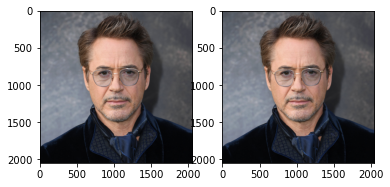

Verified: Same person | Score 1.0


In [10]:
image1 = "data/test/Robert_Downey_Jr.jpg"
image2 = "data/test/Robert_Downey_Jr.jpg"

verify_by_image(image1, image2, threshold=1)

#### Verify image by name

Verify if the given image and person given by name are same or different.

In [11]:
def verify_by_name(database, image, name, threshold=1):

    with open(database, "rb") as pkl_in: 
        database = pickle.load(pkl_in)
        
    embeddings_set, id_to_name = database
    name_to_id = {value:key for key, value in id_to_name.items()}
  
    plt.imshow(Image.open(image))

    embeddings, _ = get_embeddings(image)

    if embeddings is not None:
        dist = (embeddings_set[name_to_id[name]] - embeddings).norm().item()
        if dist < threshold:print('Match found! | Score {}'.format(1-dist))
        else:print('Match not found! | Score {}'.format(dist))

Match found! | Score 0.5193381011486053


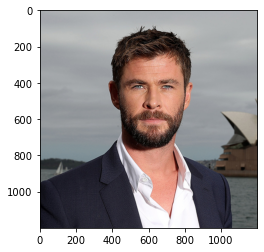

In [12]:
verify_by_name("data/database/database.pkl", "data/test/Chris_Hemsworth.jpg", "Chris_Hemsworth")

### Face Recognition

Recognize the given face by looking into the database.

In [13]:
def face_recognition(database, image, threshold=1):

    with open(database, "rb") as pkl_in: 
        database = pickle.load(pkl_in)
        
    embeddings_set, id_to_name = database
  
    plt.imshow(Image.open(image))

    embeddings, _ = get_embeddings(image)

    if embeddings is not None:
        index = (embeddings_set - embeddings).norm(dim=-1).argmin().item()
        dist = (embeddings_set - embeddings).norm(dim=-1).min().item()
  
        if dist < threshold:print('{} | Score {}'.format(id_to_name[index], 1-dist))
        else:print('Unknown | Score {}'.format(1-dist))

Scarlett_Johansson | Score 0.4534912109375


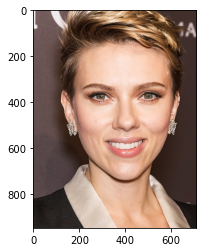

In [14]:
face_recognition("data/database/database.pkl", "data/test/Scarlett_Johansson.jpg")

In [22]:
def live_detection(database, threshold=1):
    
    with open(database, "rb") as pkl_in: 
        database = pickle.load(pkl_in)

    embeddings_set, id_to_name = database

    cap = cv2.VideoCapture(0)

    # Check if the webcam is opened correctly
    if not cap.isOpened():
        raise IOError("Cannot open webcam")

    while True:
        ret, frame = cap.read()
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        try:
            face = mtcnn(rgb)
            c, _ = mtcnn.detect(rgb)
            c = c.flatten().tolist()
            embeddings = resnet(face.unsqueeze(0).to(device)).detach()
            if embeddings is not None:
                index = (embeddings_set - embeddings).norm(dim=-1).argmin().item()
                dist = (embeddings_set - embeddings).norm(dim=-1).min().item()
                if dist < threshold:
                    name = id_to_name[index]
                else:
                    name = "Unknown"

            cv2.rectangle(frame,(int(c[0]), int(c[1])),(int(c[2]), int(c[3])), (0,0,255), 2)
            cv2.putText(frame, name, (int(c[0])-120,int(c[1])-10), cv2.FONT_HERSHEY_TRIPLEX, 1.0, [0,0,255], 2, 1)
        except Exception:
            pass


        cv2.imshow('Input', frame)

        c = cv2.waitKey(1)
        if c == 27:
            break

    cap.release()
    cv2.destroyAllWindows()

In [27]:
live_detection("data/database/database.pkl", threshold=1)